Import Libraries

In [27]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna
import joblib
import os
import unidecode
import warnings
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report,
    make_scorer,average_precision_score, r2_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split


1 Data Preprocesing

In [ ]:


# =========================
# 1. Load & Merge Spatial Data (UP + HID)
# =========================

gdf_up = gpd.read_file("up.gpkg")
gdf_hid = gpd.read_file("hid.gpkg")
if gdf_up.crs != gdf_hid.crs:
    gdf_up = gdf_up.to_crs(gdf_hid.crs)

gdf_merged_geo = gpd.sjoin(gdf_hid, gdf_up, how="inner", predicate="intersects").drop(columns="index_right")
print(f"✅ geo_data.gpkg: {len(gdf_merged_geo)} rows, {len(gdf_merged_geo.columns)} cols")

# =========================
# 2. Load Tabular Data (Mortality)
# =========================

df_tabular = pd.read_csv("mort_2022-23.csv", low_memory=False)

# Create CKD target
def contains_renal(text):
    if pd.isna(text): return 0
    return int(any(word in text.lower() for word in ["renal", "renales", "riñon"]))

desc_cols = [col for col in df_tabular.columns if "DESCRIPCIONCAUSA" in col] + [
    "CIECAUSABASICAD", "CIE_CODIGO_ADICIONALD", "CIE_CAUSA_EXTERNAD"
]
df_tabular["CKD"] = df_tabular[desc_cols].apply(lambda row: max(row.apply(contains_renal)), axis=1)
df_tabular["target"] = df_tabular.pop("CKD")
print(f"✅ df_tabular: {len(df_tabular)} rows, {len(df_tabular.columns)} cols")

# =========================
# 3.  Multimodal Fusion
# =========================

def normalize_municipio(name):
    try:
        name = unidecode.unidecode(str(name))
        return re.sub(r"\(.*\)", "", name).strip().lower()
    except:
        return ""

gdf_merged_geo["Municipio_merge"] = gdf_merged_geo["Municipio"].apply(normalize_municipio)
df_tabular["Municipio_merge"] = df_tabular["MUNICIPIORESIDENCIAD"].apply(normalize_municipio)

# Aggregate numeric geospatial features
numeric_cols = gdf_merged_geo.select_dtypes(include=["int64", "float64"]).columns.tolist()
agg_cols = [col for col in numeric_cols if col != "Municipio_merge"]
gdf_agg = gdf_merged_geo.groupby("Municipio_merge")[agg_cols].mean().reset_index()

# Include some useful categorical descriptors 
cat_cols = ["Municipio", "Clave Región Hidrológica", "Clave Cuenca", "Clave Subcuenca", "Clave Microcuenca", "Clima"]
gdf_cat = gdf_merged_geo[["Municipio_merge"] + cat_cols].drop_duplicates("Municipio_merge")
gdf_spatial_features = pd.merge(gdf_agg, gdf_cat, on="Municipio_merge", how="left")

# Merge into individual-level data (no geometry)
df_fused = pd.merge(df_tabular, gdf_spatial_features, on="Municipio_merge", how="left")
print(f"✅ Merged data shape: {df_fused.shape}")

# Save merged model
df_fused.to_csv("mm_data.csv", index=False)
print(f"💾 Saved mm_data.csv with shape {df_fused.shape}")

# =========================
# 4. Train/Test Split
# =========================

df_train, df_test = train_test_split(df_fused, test_size=0.2, random_state=42, stratify=df_fused["target"])
print(f"✅ Train: {df_train.shape}, Test: {df_test.shape}")

# =========================
# 5. Preprocessing for ML
# =========================

def preprocess(df, fit_scalers=True):
    """
    Preprocess the CKD dataset for ML.
    Filters adults, imputes missing data, encodes categoricals, scales age.

    Returns:
        - Processed DataFrame
        - StandardScaler (for SVM)
        - MinMaxScaler (for Neural Nets)
        - LabelEncoders used
    """

    df = df.copy()

    # === 1. Filter for adults only (CLAVEEDAD = 5)
    df = df[df["CLAVEEDAD"] == 5].copy()

    # === 2. Select relevant features
    features = [
        "SEXOD", "SE_RECONOCIA_AFROMEXICANOD", "SE_CONSIDERA_INDIGENAD", "EDAD",
        "ESTADOCONYUGALD", "ESCOLARIDADD", "CLAVEOCUPACIONHABITUALD",
        "TRABAJAACTUALMENTED", "AFILIACIOND", "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIAD",
        "Clave Región Hidrológica", "Clave Cuenca", "Clave Subcuenca",
        "Clave Microcuenca", "Elevación en m.", "Clima", "Municipio"
    ]
    df = df[features + ["target"]].dropna(subset=["target"])

    # === 3. Handle missing values

    # Fill unknown for specific categorical variables
    for col in ["SE_RECONOCIA_AFROMEXICANOD", "SE_CONSIDERA_INDIGENAD"]:
        df[col] = df[col].fillna("Unknown")

    # Impute elevation (best choice: median)
    elev_median = df["Elevación en m."].median()
    df["Elevación en m."] = df["Elevación en m."].fillna(elev_median)

    # === 4. Scale EDAD for different ML models
    scaler_svm = StandardScaler()
    scaler_nn = MinMaxScaler()

    if fit_scalers:
        df["EDAD_SVM"] = scaler_svm.fit_transform(df[["EDAD"]])
        df["EDAD_NN"] = scaler_nn.fit_transform(df[["EDAD"]])
    else:
        df["EDAD_SVM"] = scaler_svm.transform(df[["EDAD"]])
        df["EDAD_NN"] = scaler_nn.transform(df[["EDAD"]])

    # === 5. Encode categorical columns
    label_encoders = {}
    cat_cols = [col for col in features if df[col].dtype == "object" or col in [
        "SEXOD", "ESTADOCONYUGALD", "ESCOLARIDADD", "CLAVEOCUPACIONHABITUALD",
        "SE_RECONOCIA_AFROMEXICANOD", "SE_CONSIDERA_INDIGENAD",
        "TRABAJAACTUALMENTED", "AFILIACIOND", "CODIGOPOSTALRESIDENCIA",
        "TIPOASENTAMIENTORESIDENCIAD", "Clave Región Hidrológica", "Clave Cuenca",
        "Clave Subcuenca", "Clave Microcuenca", "Clima", "Municipio"
    ]]

    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    return df, scaler_svm, scaler_nn, label_encoders

df_train_preprocessed, scaler_svm, scaler_rnn, label_encoders = preprocess(df_train)

print(f"✅ Preprocessed train shape: {df_train_preprocessed.shape}")

df_train_preprocessed.to_csv("ml_df.csv", index=False)
print(f"💾 Saved preprocessed training data as ml_df.csv with shape {df_train_preprocessed.shape}")


✅ geo_data.gpkg: 2997 rows, 40 cols
✅ df_tabular: 107603 rows, 101 cols
✅ Merged data shape: (107603, 118)
💾 Saved mm_data.csv with shape (107603, 118)
✅ Train: (86082, 118), Test: (21521, 118)
✅ Preprocessed train shape: (84176, 21)
💾 Saved preprocessed training data as ml_df.csv with shape (84176, 21)


HPO

In [34]:
# ========================
# 📥 Load preprocessed ML dataset
# ========================
df = pd.read_csv("ml_df.csv")

X = df.drop(columns=["target"])
y = df["target"]


# ========================
# ⚖️ Define Stratified K-Fold CV
# ========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1 = make_scorer(f1_score)

# ========================
# 📦 Model Configurations
# ========================
models_config = {
    "Decision Tree": {
        "model": DecisionTreeClassifier,
        "params": lambda trial: {
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "class_weight": "balanced",
            "random_state": 42
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier,
        "params": lambda trial: {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier,
        "params": lambda trial: {
            "n_estimators": trial.suggest_int("n_estimators", 50, 200),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
            "random_state": 42
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier,
        "params": lambda trial: {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "random_state": 42
        }
    },
    "Naive Bayes": {
        "model": GaussianNB,
        "params": lambda trial: {}  # No tunable params, but still useful for baseline
    }
}

# ========================
# 🎯 Objective Function
# ========================
def objective(trial, model_name):
    config = models_config[model_name]
    model_cls = config["model"]
    model_params = config["params"](trial)
    model = model_cls(**model_params)

    y_probs = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    return average_precision_score(y, y_probs)

# ========================
# 🚀 Run Optuna per Model
# ========================
studies = {}
best_results = []

for model_name in models_config:
    print(f"🔍 Optimizing {model_name}...")

    study = optuna.create_study(direction="maximize", study_name=f"{model_name} HPO")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

    studies[model_name] = study
    best_results.append({
        "Model": model_name,
        "Best PRC AUC": round(study.best_value, 4),
        "Best Params": study.best_params
    })

# ========================
# 📊 Results Summary
# ========================
results_df = pd.DataFrame(best_results)
print("\n✅ Optimization Summary:")
display(results_df)

[I 2025-03-30 20:16:53,485] A new study created in memory with name: Decision Tree HPO


🔍 Optimizing Decision Tree...


[I 2025-03-30 20:16:57,181] Trial 0 finished with value: 0.16952601600186218 and parameters: {'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.16952601600186218.
[I 2025-03-30 20:16:58,619] Trial 1 finished with value: 0.1700232472808728 and parameters: {'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.1700232472808728.
[I 2025-03-30 20:16:59,314] Trial 2 finished with value: 0.16422903855767237 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.1700232472808728.
[I 2025-03-30 20:16:59,937] Trial 3 finished with value: 0.18534170461290306 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.18534170461290306.
[I 2025-03-30 20:17:01,234] Trial 4 finished with value: 0.19300268183231548 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is tri

🔍 Optimizing Random Forest...


[I 2025-03-30 20:18:03,122] Trial 0 finished with value: 0.23732730320063006 and parameters: {'n_estimators': 340, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.23732730320063006.
[I 2025-03-30 20:18:32,525] Trial 1 finished with value: 0.23463737420489755 and parameters: {'n_estimators': 337, 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.23732730320063006.
[I 2025-03-30 20:19:12,085] Trial 2 finished with value: 0.2203817905125775 and parameters: {'n_estimators': 407, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.23732730320063006.
[I 2025-03-30 20:19:31,682] Trial 3 finished with value: 0.23769990307998282 and parameters: {'n_estimators': 264, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.237699

🔍 Optimizing AdaBoost...


[I 2025-03-30 20:51:24,218] Trial 0 finished with value: 0.21884858913009686 and parameters: {'n_estimators': 126, 'learning_rate': 0.47490404789935536}. Best is trial 0 with value: 0.21884858913009686.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/e

🔍 Optimizing Gradient Boosting...


[I 2025-03-30 21:04:38,918] Trial 0 finished with value: 0.23309374899719726 and parameters: {'n_estimators': 163, 'learning_rate': 0.2425608671009764, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.23309374899719726.
[I 2025-03-30 21:05:10,977] Trial 1 finished with value: 0.21134065966608026 and parameters: {'n_estimators': 153, 'learning_rate': 0.25933515827081904, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.23309374899719726.
[I 2025-03-30 21:06:36,963] Trial 2 finished with value: 0.2060928930870531 and parameters: {'n_estimators': 360, 'learning_rate': 0.14707789321749848, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.23309374899719726.
[I 2025-03-30 21:07:37,275] Trial 3 finished with value: 0.20061536348673403 and parameters: {'n_estimators': 253, 'learning_rate': 0.20098626082641688, 'max_depth': 8, 'min_samples_split': 11, 'min_sa

🔍 Optimizing Naive Bayes...


[I 2025-03-30 22:07:51,333] Trial 0 finished with value: 0.1732804597122591 and parameters: {}. Best is trial 0 with value: 0.1732804597122591.
[I 2025-03-30 22:07:51,555] Trial 1 finished with value: 0.1732804597122591 and parameters: {}. Best is trial 0 with value: 0.1732804597122591.
[I 2025-03-30 22:07:51,780] Trial 2 finished with value: 0.1732804597122591 and parameters: {}. Best is trial 0 with value: 0.1732804597122591.
[I 2025-03-30 22:07:52,004] Trial 3 finished with value: 0.1732804597122591 and parameters: {}. Best is trial 0 with value: 0.1732804597122591.
[I 2025-03-30 22:07:52,249] Trial 4 finished with value: 0.1732804597122591 and parameters: {}. Best is trial 0 with value: 0.1732804597122591.
[I 2025-03-30 22:07:52,486] Trial 5 finished with value: 0.1732804597122591 and parameters: {}. Best is trial 0 with value: 0.1732804597122591.
[I 2025-03-30 22:07:52,721] Trial 6 finished with value: 0.1732804597122591 and parameters: {}. Best is trial 0 with value: 0.1732804597


✅ Optimization Summary:


Model  Best PRC AUC  \
0      Decision Tree        0.2217   
1      Random Forest        0.2397   
2           AdaBoost        0.2197   
3  Gradient Boosting        0.2438   
4        Naive Bayes        0.1733   

                                         Best Params  
0  {'max_depth': 7, 'min_samples_split': 19, 'min...  
1  {'n_estimators': 392, 'max_depth': 10, 'min_sa...  
2  {'n_estimators': 199, 'learning_rate': 0.44566...  
3  {'n_estimators': 293, 'learning_rate': 0.04127...  
4                                                 {}

In [35]:
# Create a list to collect best params per model
best_params_list = []

# Loop through your saved studies (from your HPO loop)
for model_name, study in studies.items():
    best_params = study.best_params
    best_params["Model"] = model_name
    best_params["Best PRC AUC"] = round(study.best_value, 4)
    best_params_list.append(best_params)

# Create DataFrame
best_params_df = pd.DataFrame(best_params_list)

# Optional: Reorder columns
cols = ["Model", "Best PRC AUC"] + [col for col in best_params_df.columns if col not in ["Model", "Best PRC AUC"]]
best_params_df = best_params_df[cols]

# Save to CSV
best_params_df.to_csv("best_model_parameters.csv", index=False)
print("✅ Saved best parameters to best_model_parameters.csv")

✅ Saved best parameters to best_model_parameters.csv


2 Model Training

✅ df_test_preprocessed is ready for analysis:
Shape: (21053, 21)
Columns: ['SEXOD', 'SE_RECONOCIA_AFROMEXICANOD', 'SE_CONSIDERA_INDIGENAD', 'EDAD', 'ESTADOCONYUGALD', 'ESCOLARIDADD', 'CLAVEOCUPACIONHABITUALD', 'TRABAJAACTUALMENTED', 'AFILIACIOND', 'CODIGOPOSTALRESIDENCIA', 'TIPOASENTAMIENTORESIDENCIAD', 'Clave Región Hidrológica', 'Clave Cuenca', 'Clave Subcuenca', 'Clave Microcuenca', 'Elevación en m.', 'Clima', 'Municipio', 'target', 'EDAD_SVM', 'EDAD_NN']
🚀 Training Decision Tree
🚀 Training Random Forest
🚀 Training AdaBoost


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


🚀 Training Gradient Boosting
🚀 Training SVM
🚀 Training Naive Bayes

📊 Evaluation Summary:


Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  PRC AUC
0      Decision Tree     0.540      0.181   0.659     0.284    0.633    0.222
1      Random Forest     0.613      0.195   0.577     0.292    0.643    0.241
2           AdaBoost     0.862      0.000   0.000     0.000    0.632    0.219
3  Gradient Boosting     0.863      0.689   0.018     0.034    0.646    0.244
4                SVM     0.301      0.139   0.784     0.237    0.534    0.153
5        Naive Bayes     0.862      0.000   0.000     0.000    0.578    0.176

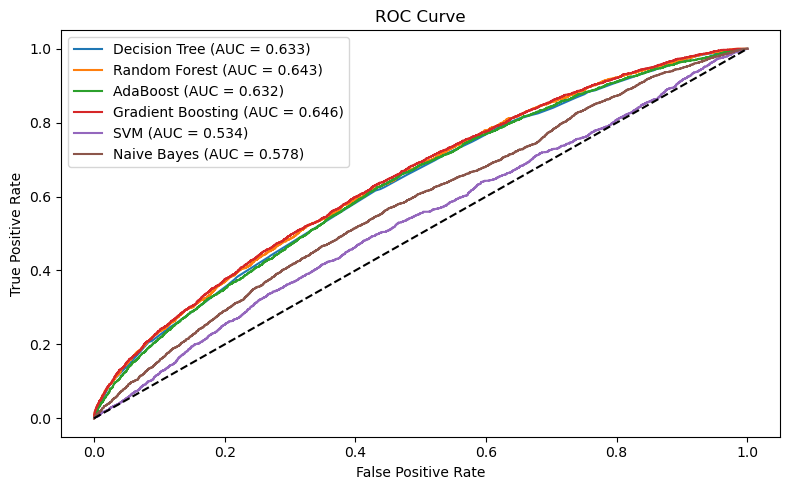

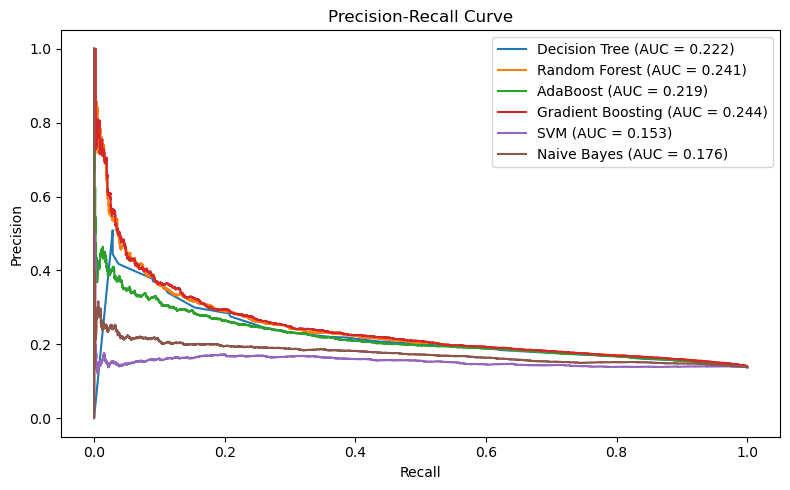


✅ Saved best model: Gradient Boosting with PRC AUC = 0.244
📁 File: best_model_Gradient_Boosting.pkl


In [36]:
# ============================
# ✅ Preprocess the test set (using training scalers & encoders)
# ============================

def preprocess_test(df, scaler_svm, scaler_nn, label_encoders, elev_median=None):
    """
    Preprocess the test split using scalers and encoders from training.
    This ensures no data leakage and keeps the test set 'unseen'.
    """
    df = df.copy()

    # Filter for adults
    df = df[df["CLAVEEDAD"] == 5].copy()

    # Features used in the model
    features = [
        "SEXOD", "SE_RECONOCIA_AFROMEXICANOD", "SE_CONSIDERA_INDIGENAD", "EDAD",
        "ESTADOCONYUGALD", "ESCOLARIDADD", "CLAVEOCUPACIONHABITUALD",
        "TRABAJAACTUALMENTED", "AFILIACIOND", "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIAD",
        "Clave Región Hidrológica", "Clave Cuenca", "Clave Subcuenca",
        "Clave Microcuenca", "Elevación en m.", "Clima", "Municipio"
    ]

    df = df[features + ["target"]].dropna(subset=["target"])

    # Handle missing values
    for col in ["SE_RECONOCIA_AFROMEXICANOD", "SE_CONSIDERA_INDIGENAD"]:
        df[col] = df[col].fillna("Unknown")

    # Impute elevation using training set median
    if elev_median is None:
        elev_median = df["Elevación en m."].median()  # fallback, just in case
    df["Elevación en m."] = df["Elevación en m."].fillna(elev_median)

    # Scale EDAD using training scalers
    df["EDAD_SVM"] = scaler_svm.transform(df[["EDAD"]])
    df["EDAD_NN"] = scaler_nn.transform(df[["EDAD"]])

    # Encode categorical columns using fitted label encoders
    for col, le in label_encoders.items():
        df[col] = df[col].astype(str)

        # Handle unseen labels
        known_classes = set(le.classes_)
        df[col] = df[col].apply(lambda x: x if x in known_classes else "Unknown")

        # Extend encoder if "Unknown" wasn't in training
        if "Unknown" not in le.classes_:
            le.classes_ = np.append(le.classes_, "Unknown")

        df[col] = le.transform(df[col])

    return df

# ================================
# 🚀 Run it to get test set ready
# ================================

# Optional: provide training elevation median if you stored it
elev_median_train = df_train["Elevación en m."].median()

df_test_preprocessed = preprocess_test(df_test, scaler_svm, scaler_rnn, label_encoders, elev_median=elev_median_train)

print("✅ df_test_preprocessed is ready for analysis:")
print(f"Shape: {df_test_preprocessed.shape}")
print(f"Columns: {df_test_preprocessed.columns.tolist()}")

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)


# ============================
# 🎯 Setup Data
# ============================
X_train = df_train_preprocessed.drop(columns=["target"])
y_train = df_train_preprocessed["target"]
X_test = df_test_preprocessed.drop(columns=["target"])
y_test = df_test_preprocessed["target"]



# ✅ Training/test split already defined:
# X_train, y_train, X_test, y_test

# ✅ 'studies' dict already populated with Optuna studies

# ============================
# 📊 Define models using best_params
# ============================

model_classes = {
    "Decision Tree": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    "AdaBoost": AdaBoostClassifier,
    "Gradient Boosting": GradientBoostingClassifier,
    "SVM": SVC,
    "Naive Bayes": GaussianNB  # No params to tune
}

models = {}
for name, model_cls in model_classes.items():
    params = studies[name].best_params if name in studies else {}

    # Always include required flags
    if name == "Random Forest":
        params.update({"class_weight": "balanced", "random_state": 42, "n_jobs": -1})
    elif name == "Decision Tree":
        params.update({"class_weight": "balanced", "random_state": 42})
    elif name == "SVM":
        params.update({"probability": True, "class_weight": "balanced", "random_state": 42})
    elif name in ["AdaBoost", "Gradient Boosting"]:
        params.update({"random_state": 42})

    models[name] = model_cls(**params)

# ============================
# 🚀 Train & Evaluate
# ============================

results = []
roc_curves = {}
prc_curves = {}

for name, model in models.items():
    print(f"🚀 Training {name}")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    prc_auc = average_precision_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "PRC AUC": prc_auc
    })

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr)
    prc_curves[name] = (recall, precision)

# ============================
# 📋 Results Table
# ============================
results_df = pd.DataFrame(results).round(3)
print("\n📊 Evaluation Summary:")
display(results_df)

# ============================
# 📈 ROC Curve
# ============================
plt.figure(figsize=(8, 5))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, models[name].predict_proba(X_test)[:,1]):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 📈 Precision-Recall Curve
# ============================
plt.figure(figsize=(8, 5))
for name, (recall, precision) in prc_curves.items():
    plt.plot(recall, precision, label=f"{name} (AUC = {average_precision_score(y_test, models[name].predict_proba(X_test)[:,1]):.3f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# ✅ Identify & Save Best Model
# ============================

# Choose metric to rank by: "PRC AUC", "F1 Score", etc.
metric_to_use = "PRC AUC"  # or "F1 Score"

# Convert results_df to use model name as index (optional)
results_df.set_index("Model", inplace=True)

# Get best model name
best_model_name = results_df[metric_to_use].idxmax()
best_model_score = results_df[metric_to_use].max()

# Extract and save model
best_model = models[best_model_name]
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")

print(f"\n✅ Saved best model: {best_model_name} with {metric_to_use} = {best_model_score:.3f}")
print(f"📁 File: best_model_{best_model_name.replace(' ', '_')}.pkl")


NN

3 Explainability Analysis 

✅ Loaded model: Gradient Boosting

🔎 Running SHAP for Gradient Boosting...


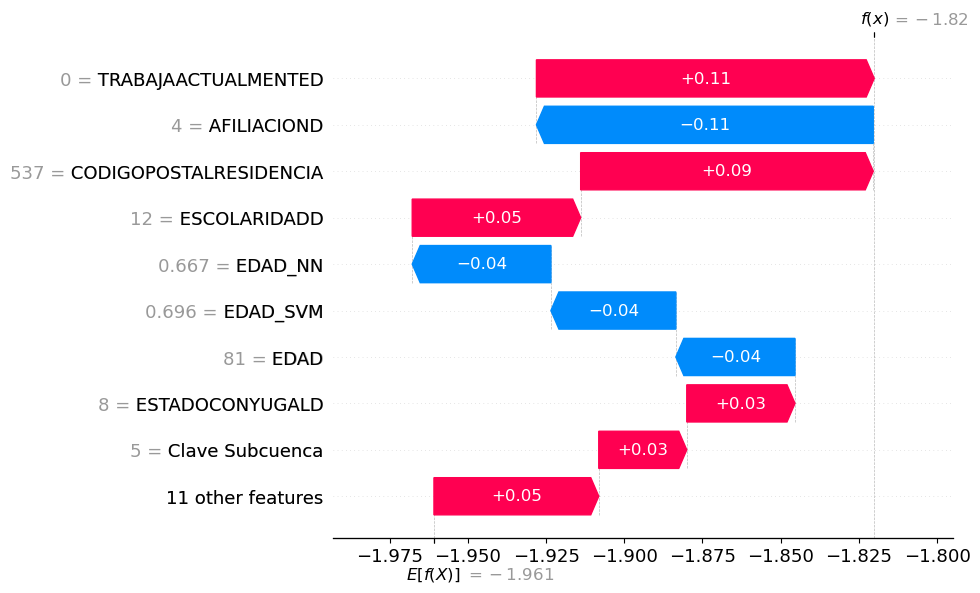

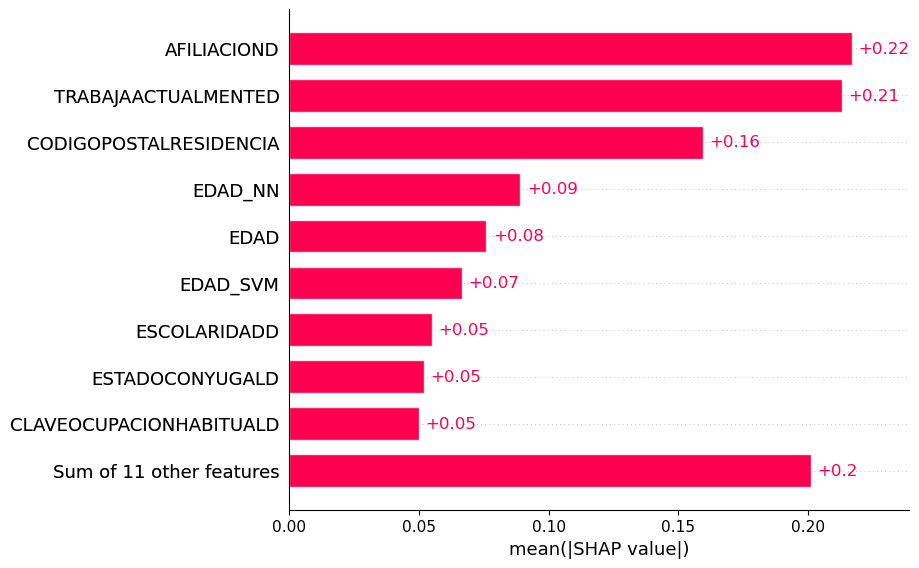

📈 SHAP Fidelity (R²): -965.5648
🧠 SHAP Interpretability (avg # non-zero features): 20.00
⚖️ SHAP FII (Fidelity / Interpretability): -48.2782

🔎 Running LIME for Gradient Boosting...


/opt/anaconda3/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

📈 LIME Fidelity (1 - MSE): 1.0000
🧠 LIME Interpretability (avg # non-zero features): 10.00
⚖️ LIME FII (Fidelity / Interpretability): 0.1000

📊 LIME Explanations:

🔎 LIME Explanation for Sample #0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/lib/python3.12/site-packages/lime/lime_tabular.py:427: FutureWarning: S


🔎 LIME Explanation for Sample #1



🔎 LIME Explanation for Sample #2



✅ Explanation Quality Summary:


Explainer    Fidelity  Interpretability        FII
0      SHAP -965.564846              20.0 -48.278242
1      LIME    1.000000              10.0   0.100000

In [46]:

from sklearn.metrics import r2_score


# ========================
# 📥 Load best model
# ========================
best_model_name = results_df[metric_to_use].idxmax()
best_model_path = f"best_model_{best_model_name.replace(' ', '_')}.pkl"
best_model = joblib.load(best_model_path)

print(f"✅ Loaded model: {best_model_name}")

# Subset for explanation
X_sample = X_test.sample(n=100, random_state=42)
X_train_sample = X_train.copy()

# ========================
# 🔍 SHAP Explanations
# ========================
print(f"\n🔎 Running SHAP for {best_model_name}...")

# Choose correct SHAP explainer
try:
    explainer_shap = shap.Explainer(best_model, X_train_sample)
except:
    explainer_shap = shap.Explainer(best_model.predict, X_train_sample)

shap_values = explainer_shap(X_sample)

# 🌊 Waterfall plot for first prediction
shap.plots.waterfall(shap_values[0], max_display=10)

# 📊 Global bar plot
shap.plots.bar(shap_values)

# 📈 SHAP Fidelity
y_pred = best_model.predict_proba(X_sample)[:, 1]
y_expl_shap = shap_values.values.sum(axis=1) + shap_values.base_values
shap_fidelity = r2_score(y_pred, y_expl_shap)
shap_interpretability = np.mean([np.count_nonzero(row) for row in shap_values.values])
shap_fii = shap_fidelity / shap_interpretability

print(f"📈 SHAP Fidelity (R²): {shap_fidelity:.4f}")
print(f"🧠 SHAP Interpretability (avg # non-zero features): {shap_interpretability:.2f}")
print(f"⚖️ SHAP FII (Fidelity / Interpretability): {shap_fii:.4f}")

# ========================
# 🔍 LIME Explanations
# ========================
print(f"\n🔎 Running LIME for {best_model_name}...")

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_sample),
    feature_names=X_train_sample.columns.tolist(),
    class_names=["No CKD", "CKD"],
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

lime_fidelity_scores = []
lime_interpretability_scores = []

# Store explanations for visualization
lime_explanations = []

for i in range(len(X_sample)):
    exp = explainer_lime.explain_instance(
        data_row=X_sample.iloc[i],
        predict_fn=best_model.predict_proba,
        num_features=10
    )
    lime_explanations.append(exp)

    # Fidelity (squared error between predicted and explained)
    y_model = best_model.predict_proba([X_sample.iloc[i]])[0][1]
    y_lime = exp.predict_proba[1]
    lime_fidelity_scores.append((y_lime - y_model) ** 2)

    # Interpretability = # features used
    non_zero_features = sum(1 for feat, weight in exp.as_list() if abs(weight) > 1e-4)
    lime_interpretability_scores.append(non_zero_features)

# Fidelity and interpretability
lime_fidelity = 1 - np.mean(lime_fidelity_scores)
lime_interpretability = np.mean(lime_interpretability_scores)
lime_fii = lime_fidelity / lime_interpretability

print(f"📈 LIME Fidelity (1 - MSE): {lime_fidelity:.4f}")
print(f"🧠 LIME Interpretability (avg # non-zero features): {lime_interpretability:.2f}")
print(f"⚖️ LIME FII (Fidelity / Interpretability): {lime_fii:.4f}")

# ✅ Plot first 3 explanations
print("\n📊 LIME Explanations:")
for i in range(3):
    print(f"\n🔎 LIME Explanation for Sample #{i}")
    lime_explanations[i].show_in_notebook(show_table=True)

# ========================
# 📊 Summary Table
# ========================
summary = pd.DataFrame({
    "Explainer": ["SHAP", "LIME"],
    "Fidelity": [shap_fidelity, lime_fidelity],
    "Interpretability": [shap_interpretability, lime_interpretability],
    "FII": [shap_fii, lime_fii]
})

print("\n✅ Explanation Quality Summary:")
display(summary)


4  Interpretability & Visualization

In [ ]:
#grad, boosting {'n_estimators': 196, 'learning_rate': 0.09766935065865037, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 3}.

In [ ]:
#LASSO regression, XGBoost, KNN, GBDT, GBM, XGBoost